In [123]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDClassifier
import statsmodels.api as sm

In [147]:
df_without_date['константа'] = 1

df_without_date = df_without_date.drop(columns=['Объём вал рынка, $'])

vif_data = pd.DataFrame()

vif_data["Признак"] = df_without_date.columns
vif_data["VIF"] = [variance_inflation_factor(df_without_date.values, i) for i in range(df_without_date.shape[1])]

vif_data

,Признак,VIF
0,Доля доллара,10.335931
1,Фикс. вал. курс,20.256953
2,Курс USD/RUB,54.876729
3,Волатильность USD/RUB,3.312131
4,"Объём торгов нефти, ₽",10.824615
5,Индекс моекс,60.153176
6,Уровень цен,72.335952
7,Реальный индекс моекс,8.188263
8,"Импорт, $",25.220841
9,"Импорт, ₽",72.741729


In [148]:
del df_without_date['Уровень цен']
del df_without_date['Индекс моекс']
del df_without_date['Курс USD/RUB']
del df_without_date['Торговый баланс, $']
del df_without_date['Импорт, ₽']
del df_without_date['Волатильность USD/RUB']

vif_data = vif_data.drop(index=6)
vif_data = vif_data.drop(index=5)
vif_data = vif_data.drop(index=2)
vif_data = vif_data.drop(index=10)
vif_data = vif_data.drop(index=9)
vif_data = vif_data.drop(index=3)

vif_data["Признак"] = df_without_date.columns
vif_data["VIF"] = [variance_inflation_factor(df_without_date.values, i) for i in range(df_without_date.shape[1])]

vif_data

,Признак,VIF
0,Доля доллара,2.838909
1,Фикс. вал. курс,2.868401
4,"Объём торгов нефти, ₽",4.354599
7,Реальный индекс моекс,1.391463
8,"Импорт, $",4.756189
11,"ЗВР, $",6.395563
12,константа,108.883640


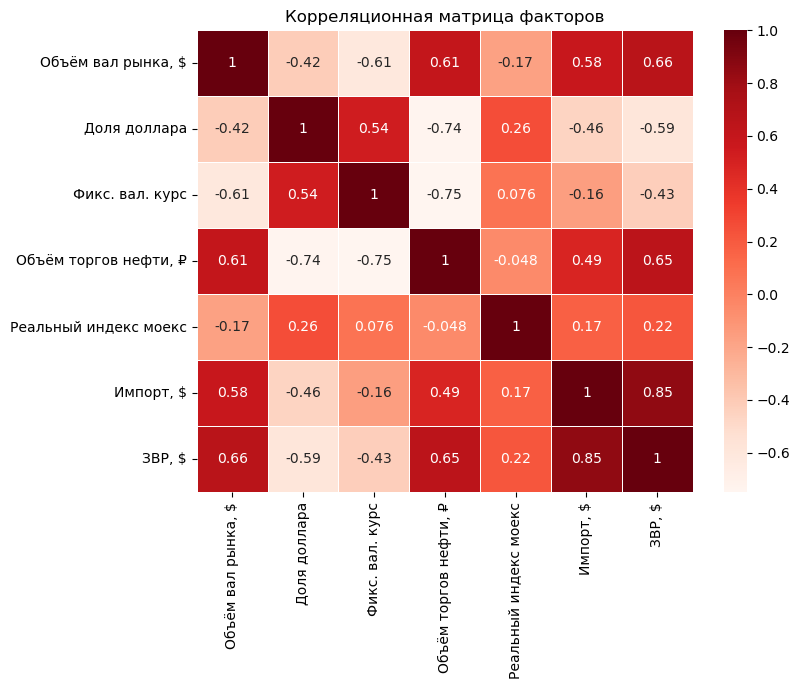

In [149]:
del df_merged['Уровень цен']
del df_merged['Индекс моекс']
del df_merged['Курс USD/RUB']
del df_merged['Импорт, ₽']
del df_merged['Торговый баланс, $']
del df_merged['Волатильность USD/RUB']

df_without_date = df_merged.drop(columns=['Дата'])
correlation_matrix = df_without_date.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Корреляционная матрица факторов')

plt.show()

In [150]:
df_forecast = pd.read_csv('прогноз модели - Лист1.csv')

df_forecast = df_forecast.rename(columns={'Объём вал рынка, ₽': 'Объём вал рынка, $'})

df_forecast['Доля доллара'] = df_forecast['Доля доллара'].map(correct_values, na_action='ignore')
df_forecast['Доля доллара'] = pd.to_numeric(df_forecast['Доля доллара'], errors='coerce')

df_forecast['Объём торгов нефти, ₽'] = pd.to_numeric(df_forecast['Объём торгов нефти, ₽'], errors='coerce')

df_forecast['Реальный индекс моекс'] = df_forecast['Реальный индекс моекс'].map(correct_values, na_action='ignore')
df_forecast['Реальный индекс моекс'] = pd.to_numeric(df_forecast['Реальный индекс моекс'], errors='coerce')

df_forecast = df_forecast.rename(columns={'Импорт': 'Импорт, $'})
df_forecast['Импорт, $'] = df_forecast['Импорт, $'].map(correct_values, na_action='ignore')
df_forecast['Импорт, $'] = pd.to_numeric(df_forecast['Импорт, $'], errors='coerce')

df_forecast = df_forecast.rename(columns={'ЗВР': 'ЗВР, $'})
df_forecast['ЗВР, $'] = df_forecast['ЗВР, $'].map(correct_values, na_action='ignore')
df_forecast['ЗВР, $'] = pd.to_numeric(df_forecast['ЗВР, $'], errors='coerce')

df_forecast['Дата'] = pd.to_datetime(df_forecast['Дата'])

del df_forecast['Волатильность USD/RUB']

In [151]:
y = df_merged['Объём вал рынка, $'] #target

X_raw_1 = df_merged.drop(columns = ['Дата','Объём вал рынка, $'])
X_raw_2 = df_forecast.drop(columns = ['Дата','Объём вал рынка, $'])

df = pd.DataFrame(np.vstack((X_raw_1,X_raw_2)), columns = X_raw_1.columns)

In [152]:
min_max_sc = MinMaxScaler()
min_max_sc.fit(df)

df_scaled = pd.DataFrame(min_max_sc.transform(df), columns = df.columns)

df_forecast = df_scaled[252:]
df_scaled = df_scaled[:252]

df_scaled['Фикс. вал. курс']= df_merged['Фикс. вал. курс']

In [153]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size = 0.3, random_state = 0)

lr = LinearRegression()
lr.fit(X_train,y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Среднеквадратичная ошибка на тренировочной выборке:", mse_train)
print("Среднеквадратичная ошибка на тестовой выборке:", mse_test)

print((r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)), end = '\n\n')

coefs = lr.coef_

for col, coef in zip(X_train.columns, coefs):
    print(f'{col} -> {coef}')

w0 = lr.intercept_

Среднеквадратичная ошибка на тренировочной выборке: 14573866.315988032
Среднеквадратичная ошибка на тестовой выборке: 15113925.520747995
(0.7398086875492628, 0.726919311494431)

Доля доллара -> 15019.771336547825
Фикс. вал. курс -> -7044.447308871524
Объём торгов нефти, ₽ -> 6355.540016858074
Реальный индекс моекс -> -12407.993484711096
Импорт, $ -> 14337.196671077547
ЗВР, $ -> 14071.460240084583


In [154]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)

results = model.fit()

p_values = results.pvalues

print("P-значения для каждого фактора:")
print(p_values)

P-значения для каждого фактора:
const                    1.702524e-01
Доля доллара             2.233454e-08
Фикс. вал. курс          2.778211e-11
Объём торгов нефти, ₽    8.905462e-02
Реальный индекс моекс    1.259996e-13
Импорт, $                3.008798e-06
ЗВР, $                   3.054071e-04
dtype: float64


In [155]:
df_forecast['Объём вал рынка, $'] = 15019.771336547825*df_forecast['Доля доллара'] - 7044.447308871524*df_forecast['Фикс. вал. курс'] + 6355.540016858074*df_forecast['Объём торгов нефти, ₽'] - 12407.993484711096*df_forecast['Реальный индекс моекс'] + 14337.196671077547*df_forecast['Импорт, $'] + 14071.460240084583*df_forecast['ЗВР, $'] + w0

df_forecast

,Доля доллара,Фикс. вал. курс,"Объём торгов нефти, ₽",Реальный индекс моекс,"Импорт, $","ЗВР, $","Объём вал рынка, $"
252,0.001591,0.0,0.497831,0.386534,0.783862,0.722390,16002.794581
253,0.000000,0.0,0.552465,0.428865,0.833728,0.784087,17383.992114
254,0.021159,0.0,0.613000,0.473595,0.886276,0.850659,19221.663842
255,0.043948,0.0,0.680073,0.520860,0.941649,0.922491,21208.471901
256,0.068585,0.0,0.754389,0.570802,1.000000,1.000000,23358.397872


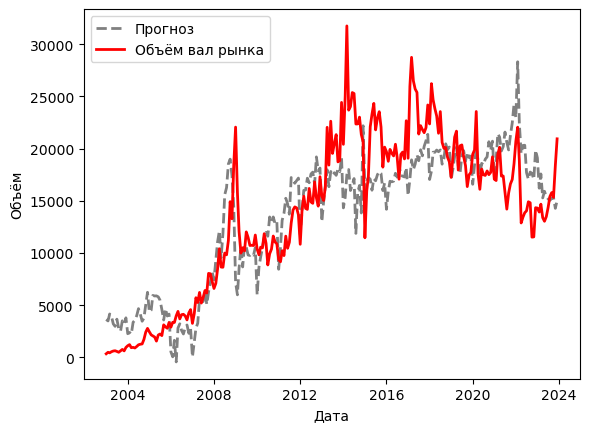

In [156]:
df_merged['Прогноз'] = 15019.771336547825*df_scaled['Доля доллара'] - 7044.447308871524*df_scaled['Фикс. вал. курс'] + 6355.540016858074*df_scaled['Объём торгов нефти, ₽'] - 12407.993484711096*df_scaled['Реальный индекс моекс'] + 14337.196671077547*df_scaled['Импорт, $'] + 14071.460240084583*df_scaled['ЗВР, $'] + w0
plt.plot(df_merged['Дата'], df_merged['Прогноз'], color='grey', linestyle='--', linewidth=2, label='Прогноз')
plt.plot(df_merged['Дата'], df_merged['Объём вал рынка, $'], color='red', linewidth=2, label='Объём вал рынка')

plt.xlabel('Дата')  
plt.ylabel('Объём')  

plt.legend()

plt.show()

In [157]:
volume_column = df_forecast['Объём вал рынка, $']

df_forecast.drop(columns=['Объём вал рынка, $'], inplace=True)

df_forecast.insert(0, 'Объём вал рынка, $', volume_column)

new_dates = pd.Series(['2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01', '2028-01-01'], name='Дата')
new_dates = new_dates.rename(index={0: 252, 1: 253, 2: 254, 3: 255, 4: 256})

df_forecast['Дата'] = new_dates

date_column = df_forecast['Дата']

df_forecast.drop(columns=['Дата'], inplace=True)

df_forecast.insert(0, 'Дата', date_column)

df_forecast['Дата'] = pd.to_datetime(df_forecast['Дата'])

In [158]:
df_merged = pd.concat([df_merged, df_forecast], ignore_index=True)

data_2013_2016 = df_merged.loc[(df_merged['Дата'] >= pd.Timestamp('2013-01-01')) & (df_merged['Дата'] <= pd.Timestamp('2016-12-01'))]

std_2013_2016 = data_2013_2016['Объём вал рынка, $'].std()

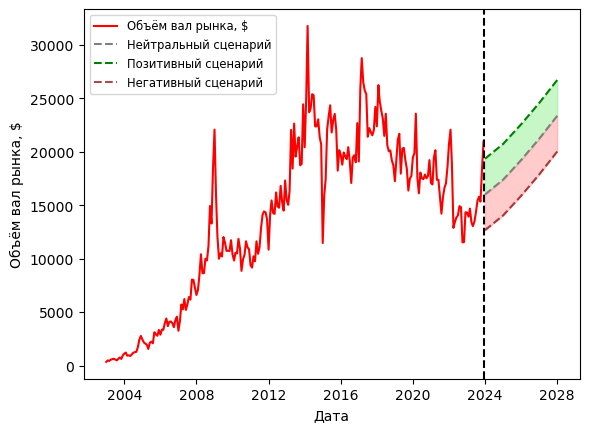

In [159]:
data_before = df_merged[df_merged['Дата'] <= pd.Timestamp('2023-12-01')]
data_after = df_merged[df_merged['Дата'] > pd.Timestamp('2023-12-01')]

plt.plot(data_before['Дата'], data_before['Объём вал рынка, $'], color='red', label='Объём вал рынка, $')
plt.plot(data_after['Дата'], data_after['Объём вал рынка, $'], color='gray', linestyle='--', label='Нейтральный сценарий')

plt.axvline(pd.Timestamp('2023-12-01'), color='black', linestyle='--')

new_values = data_after['Объём вал рынка, $'].reset_index(drop=True) + std_2013_2016
new_dates = data_after['Дата'].reset_index(drop=True)

plt.plot(new_dates, new_values, color='green', linestyle='--', label='Позитивный сценарий')

plt.fill_between(data_after['Дата'], data_after['Объём вал рынка, $'], new_values, where=(data_after['Дата'] >= pd.Timestamp('2023-12-01')), color='lightgreen', alpha=0.5)

new_values = data_after['Объём вал рынка, $'].reset_index(drop=True) - std_2013_2016
new_dates = data_after['Дата'].reset_index(drop=True)

plt.plot(new_dates, new_values, color=(0.5, 0.0, 0.0, 0.7), linestyle='--', label='Негативный сценарий')

plt.fill_between(data_after['Дата'], data_after['Объём вал рынка, $'], new_values, where=(data_after['Дата'] >= pd.Timestamp('2023-12-01')), color=(1.0, 0.6, 0.6, 0.5), alpha=0.5)

plt.xlabel('Дата')
plt.ylabel('Объём вал рынка, $')
plt.legend(loc='upper left', fontsize='small')

plt.show()

In [160]:
df_individuals = pd.read_csv('ФЛ.csv', sep=';')

del df_individuals['Unnamed: 2']
del df_individuals['Unnamed: 3']
df_individuals = df_individuals.dropna()

df_individuals['Доля ФЛ'] = df_individuals['Доля ФЛ'].map(correct_values, na_action='ignore')
df_individuals['Доля ФЛ'] = pd.to_numeric(df_individuals['Доля ФЛ'], errors='coerce')

df_individuals = df_individuals.rename(columns={"Месяц":"Дата"}) 
df_individuals['Дата'] = pd.to_datetime(df_individuals['Дата'])

df_individuals

,Дата,Доля ФЛ
0,2013-01-01,0.006203
1,2013-02-01,0.003141
2,2013-03-01,0.003114
3,2013-04-01,0.004378
4,2013-05-01,0.005336
...,...,...
127,2023-08-01,0.081498
128,2023-09-01,0.077884
129,2023-10-01,0.070633
130,2023-11-01,0.071082


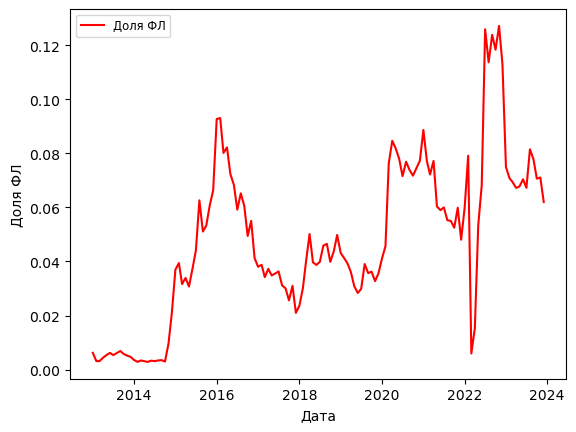

In [161]:
plt.plot(df_individuals['Дата'], df_individuals['Доля ФЛ'], color='red', label='Доля ФЛ')

plt.xlabel('Дата')
plt.ylabel('Доля ФЛ')
plt.legend(loc='upper left', fontsize='small')

plt.show()

In [162]:
df_individuals['Месяц'] = df_individuals['Дата'].dt.month

month = df_individuals.groupby(['Месяц'])['Доля ФЛ'].mean()

df_individuals_month = pd.DataFrame(month)
df_individuals_month = df_individuals_month.reset_index()
df_individuals_month

,Месяц,Доля ФЛ
0,1,0.046258
1,2,0.047394
2,3,0.041431
3,4,0.044684
4,5,0.043632
5,6,0.044852
6,7,0.049314
7,8,0.052796
8,9,0.051339
9,10,0.047853


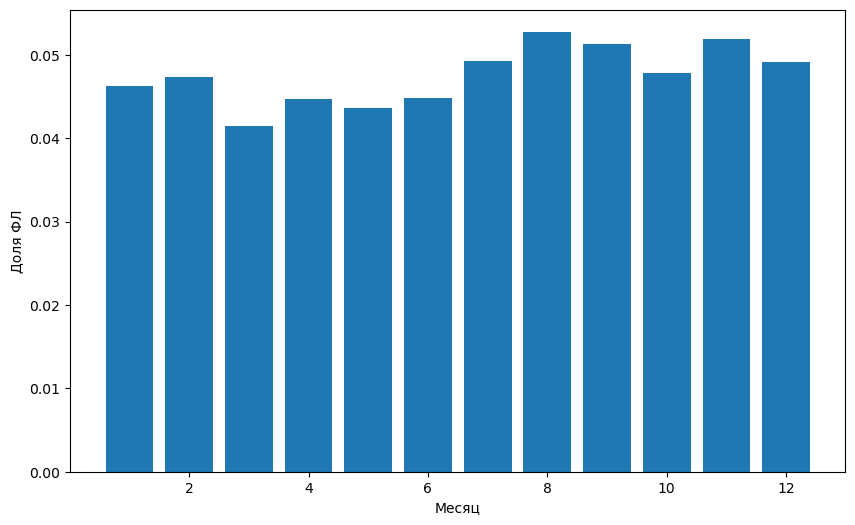

In [163]:
plt.figure(figsize=(10, 6))

plt.bar(df_individuals_month['Месяц'], df_individuals_month['Доля ФЛ'])

plt.xlabel('Месяц')
plt.ylabel('Доля ФЛ')

plt.show()

In [164]:
df_individuals_month['Доля ФЛ'].mean()

0.047545423378787886

In [165]:
df_individuals_month['Соотношение от среднего'] = df_individuals_month['Доля ФЛ'] / df_individuals_month['Доля ФЛ'].mean()

In [166]:
df_individuals_month

,Месяц,Доля ФЛ,Соотношение от среднего
0,1,0.046258,0.972930
1,2,0.047394,0.996824
2,3,0.041431,0.871391
3,4,0.044684,0.939828
4,5,0.043632,0.917683
5,6,0.044852,0.943340
6,7,0.049314,1.037193
7,8,0.052796,1.110428
8,9,0.051339,1.079787
9,10,0.047853,1.006478


In [167]:
df_individuals['ГОД'] = df_individuals['Дата'].dt.year

year = df_individuals.groupby(['ГОД'])['Доля ФЛ'].mean()

df_individuals_year = pd.DataFrame(year)
df_individuals_year = df_individuals_year.reset_index()
df_individuals_year

,ГОД,Доля ФЛ
0,2013,0.005190
1,2014,0.005223
2,2015,0.045685
3,2016,0.068277
4,2017,0.032812
5,2018,0.040673
6,2019,0.035682
7,2020,0.071116
8,2021,0.063766
9,2022,0.083666


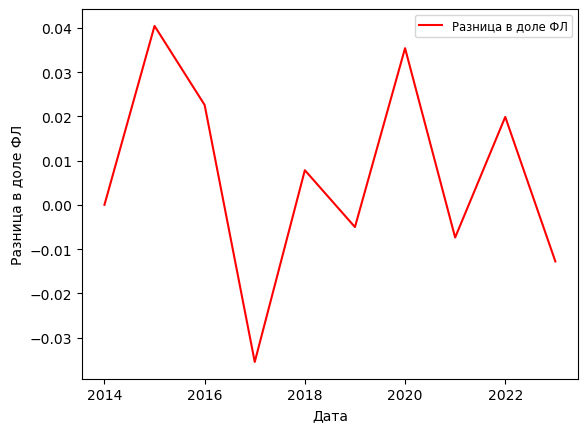

In [168]:
df_individuals_year['Доля ФЛ_diff'] = df_individuals_year['Доля ФЛ'].diff()

plt.plot(df_individuals_year['ГОД'] ,df_individuals_year['Доля ФЛ_diff'], color='red', label='Разница в доле ФЛ')


plt.xlabel('Дата')
plt.ylabel('Разница в доле ФЛ')
plt.legend(loc='upper right', fontsize='small')

plt.show()

In [169]:
df_individuals_year

,ГОД,Доля ФЛ,Доля ФЛ_diff
0,2013,0.005190,NaN
1,2014,0.005223,0.000033
2,2015,0.045685,0.040462
3,2016,0.068277,0.022592
4,2017,0.032812,-0.035465
5,2018,0.040673,0.007861
6,2019,0.035682,-0.004991
7,2020,0.071116,0.035434
8,2021,0.063766,-0.007350
9,2022,0.083666,0.019900


In [170]:
df_individuals_positive = df_individuals_year['Доля ФЛ_diff'].iloc[2:]
positive_diff = df_individuals_positive[df_individuals_positive > 0].mean()
negative_diff = df_individuals_positive[df_individuals_positive < 0].mean()
positive_diff, negative_diff

(0.02524993326666667, -0.015140135062499999)

In [171]:
df_individuals_forecast = pd.read_csv('Доля ФЛ прогноз - Лист1.csv')

df_individuals_forecast = df_individuals_forecast.dropna(axis=1)

df_individuals_forecast['Доля ФЛ'] = df_individuals_forecast['Доля ФЛ'].map(correct_values, na_action='ignore')
df_individuals_forecast['Доля ФЛ'] = pd.to_numeric(df_individuals_forecast['Доля ФЛ'], errors='coerce')

df_individuals_forecast['Дата'] = pd.to_datetime(df_individuals_forecast['Дата'])

In [172]:
df_combined = pd.concat([df_individuals, df_individuals_forecast], axis=0)

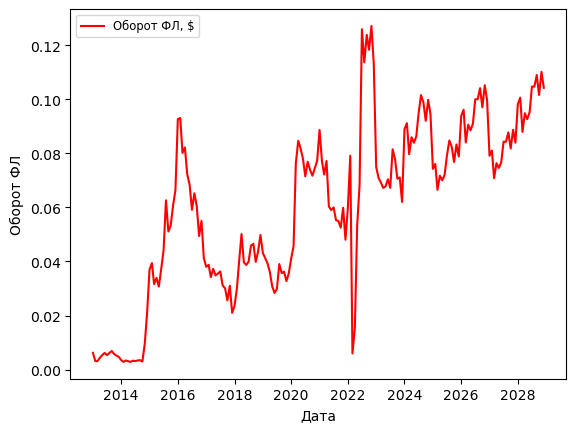

In [173]:
plt.plot(df_combined['Дата'], df_combined['Доля ФЛ'], color='red', label='Оборот ФЛ, $')

plt.xlabel('Дата')
plt.ylabel('Оборот ФЛ')
plt.legend(loc='upper left', fontsize='small')

plt.show()

In [174]:
df_combined = df_combined.merge(df_merged, how='left', on='Дата')
df_combined

,Дата,Доля ФЛ,Месяц,ГОД,"Объём вал рынка, $",Доля доллара,Фикс. вал. курс,"Объём торгов нефти, ₽",Реальный индекс моекс,"Импорт, $","ЗВР, $",Прогноз
0,2013-01-01,0.006203,1.0,2013.0,15455.809345,0.798780,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837
1,2013-02-01,0.003141,2.0,2013.0,15033.248539,0.780258,1.0,8.375503e+09,584.157014,26.5,529.875,14947.464310
2,2013-03-01,0.003114,3.0,2013.0,16328.777487,0.781722,1.0,1.258391e+10,563.580552,28.4,523.100,16391.150677
3,2013-04-01,0.004378,4.0,2013.0,22043.903622,0.805898,1.0,1.501207e+10,540.183549,29.8,519.425,17978.946304
4,2013-05-01,0.005336,5.0,2013.0,18424.024446,0.794511,1.0,1.356853e+10,522.814055,26.4,519.680,16352.394844
...,...,...,...,...,...,...,...,...,...,...,...,...
187,2028-08-01,0.104694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,2028-09-01,0.108993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,2028-10-01,0.101594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,2028-11-01,0.110153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
df_combined['ГОД'] = df_combined['Дата'].dt.year
df_combined

,Дата,Доля ФЛ,Месяц,ГОД,"Объём вал рынка, $",Доля доллара,Фикс. вал. курс,"Объём торгов нефти, ₽",Реальный индекс моекс,"Импорт, $","ЗВР, $",Прогноз
0,2013-01-01,0.006203,1.0,2013,15455.809345,0.798780,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837
1,2013-02-01,0.003141,2.0,2013,15033.248539,0.780258,1.0,8.375503e+09,584.157014,26.5,529.875,14947.464310
2,2013-03-01,0.003114,3.0,2013,16328.777487,0.781722,1.0,1.258391e+10,563.580552,28.4,523.100,16391.150677
3,2013-04-01,0.004378,4.0,2013,22043.903622,0.805898,1.0,1.501207e+10,540.183549,29.8,519.425,17978.946304
4,2013-05-01,0.005336,5.0,2013,18424.024446,0.794511,1.0,1.356853e+10,522.814055,26.4,519.680,16352.394844
...,...,...,...,...,...,...,...,...,...,...,...,...
187,2028-08-01,0.104694,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,2028-09-01,0.108993,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,2028-10-01,0.101594,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,2028-11-01,0.110153,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
year = df_combined.groupby(['ГОД'])['Объём вал рынка, $'].mean()

df_volume_year = pd.DataFrame(year)
df_volume_year = df_volume_year.reset_index()

In [177]:
df_volume_year = df_volume_year.loc[df_volume_year.index.repeat(12)].reset_index(drop=True)
df_volume_year

,ГОД,"Объём вал рынка, $"
0,2013,19442.517723
1,2013,19442.517723
2,2013,19442.517723
3,2013,19442.517723
4,2013,19442.517723
...,...,...
187,2028,23358.397872
188,2028,23358.397872
189,2028,23358.397872
190,2028,23358.397872


In [178]:
df_volume_year = df_volume_year.rename(columns={'Объём вал рынка, $': 'Средний объём вал рынка, $'})
df_combined = df_combined.merge(df_volume_year, how='left', on='ГОД')
df_combined

,Дата,Доля ФЛ,Месяц,ГОД,"Объём вал рынка, $",Доля доллара,Фикс. вал. курс,"Объём торгов нефти, ₽",Реальный индекс моекс,"Импорт, $","ЗВР, $",Прогноз,"Средний объём вал рынка, $"
0,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
1,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
2,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
3,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
4,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,2028-12-01,0.104255,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872
2300,2028-12-01,0.104255,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872
2301,2028-12-01,0.104255,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872
2302,2028-12-01,0.104255,NaN,2028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872


In [179]:
df_combined['Объём вал рынка, $'] = df_combined['Объём вал рынка, $'].fillna(df_combined['Средний объём вал рынка, $'])
df_combined

,Дата,Доля ФЛ,Месяц,ГОД,"Объём вал рынка, $",Доля доллара,Фикс. вал. курс,"Объём торгов нефти, ₽",Реальный индекс моекс,"Импорт, $","ЗВР, $",Прогноз,"Средний объём вал рынка, $"
0,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
1,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
2,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
3,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
4,2013-01-01,0.006203,1.0,2013,15455.809345,0.79878,1.0,1.118222e+10,611.430773,21.7,531.225,13006.633837,19442.517723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,2028-12-01,0.104255,NaN,2028,23358.397872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872
2300,2028-12-01,0.104255,NaN,2028,23358.397872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872
2301,2028-12-01,0.104255,NaN,2028,23358.397872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872
2302,2028-12-01,0.104255,NaN,2028,23358.397872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23358.397872


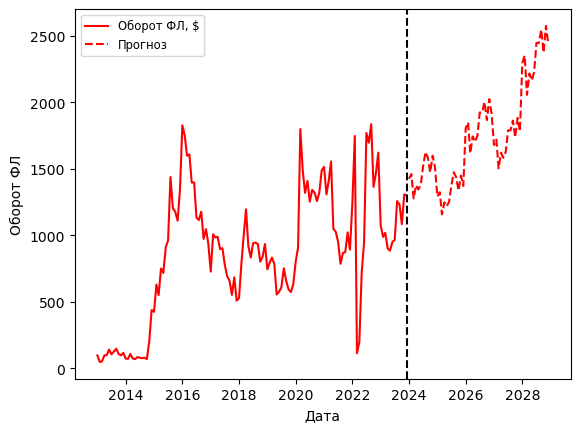

In [180]:
df_combined['Оборот ФЛ'] = df_combined['Доля ФЛ']*df_combined['Объём вал рынка, $']

data_before = df_combined[df_combined['Дата'] <= pd.Timestamp('2023-12-01')]
data_after = df_combined[df_combined['Дата'] > pd.Timestamp('2023-12-01')]

plt.plot(data_before['Дата'], data_before['Оборот ФЛ'], color='red', label='Оборот ФЛ, $')
plt.plot(data_after['Дата'], data_after['Оборот ФЛ'], color='red', linestyle='--', label='Прогноз')

plt.axvline(pd.Timestamp('2023-12-01'), color='black', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Оборот ФЛ')
plt.legend(loc='upper left', fontsize='small')

plt.show()